# Лабораторная работа №3
> Выполнили:  
> – 339080, Дьячихин Данила Никитич  
> – 368606, Овчинников Павел Алексеевич

**Цель работы:** построить модель регрессии на основе модели k ближайших соседей и модели классификации на основе алгоритма логистической регрессии.

**Инструменты:** модели регрессии (`KNeighborsRegressor`) и классификации (`LogisticRegression`) из пакета scikit-learn.

Будем использовать датасеты, полученные в результате выполнения лабораторной работы №1: `Advertising_preprocessed.csv` и `heart_preprocessed.csv`

Импортируем необходимые библиотеки и загрузим датасеты

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt

advertising = pd.read_csv('Advertising_preprocessed.csv')
heart = pd.read_csv('heart_preprocessed.csv')
print(advertising.info())
print(heart.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         198 non-null    float64
 1   radio      198 non-null    float64
 2   newspaper  198 non-null    float64
 3   sales      198 non-null    float64
 4   n/(n+r)    198 non-null    float64
dtypes: float64(5)
memory usage: 7.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       296 non-null    float64
 1   sex       296 non-null    int64  
 2   cp        296 non-null    int64  
 3   trestbps  296 non-null    float64
 4   chol      296 non-null    float64
 5   fbs       296 non-null    int64  
 6   restecg   296 non-null    int64  
 7   thalach   296 non-null    float64
 8   exang     296 non-null    int64  
 9   oldpeak   296 non-null    float6

#   Регрессия - KNeighborsRegressor

Основные указания пункта:
>1.Количество соседей `n_neighbors`: не менее 3 различных значе- ний. Обязательно рассмотреть случай `n_neighbors` = 1;  
>2.Вес объектов weights: рассмотреть `uniform` и `distance`;  
>3.Метрика: метрика городских кварталов (`cityblock`), евклидова метрика (`euclidean`) и метрика Чебышева (`scipy.spatial.distance.chebyshev`).  
>4.Используя GridSearchCV определить лучший регрессор.  

Разобьем данные на обучающую и тестовую выборки (соотношение - 80/20)

In [ ]:
X_reg = advertising.drop(columns=['sales'])
y_reg = advertising['sales']

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

Зададим параметры для перебора в регрессоре

1.`n_neighbors` — Количество ближайших соседей.  
Определяет, сколько соседей учитывать при прогнозировании.

2.`weights` — Веса соседей.  
>`uniform` — все соседи равнозначны, их влияние одинаковое.  
>`distance` — соседи с меньшим расстоянием к точке имеют больший вес.  

3.`metric` — Метрика расстояния
>`euclidean` (Евклидово расстояние) - стандартная метрика расстояний в многомерном пространстве.  
>`cityblock` (Манхэттенское расстояние) - сумма абсолютных разностей координат.  
>`chebyshev` (Расстояние Чебышева) - наибольшая разность по отдельным координатам.  

In [ ]:
knn_params = {
    'n_neighbors': [1, 3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['cityblock', 'euclidean', 'chebyshev']
}

Обучим модель регрессии

In [ ]:
knn_regressor = KNeighborsRegressor()
knn_grid = GridSearchCV(knn_regressor, param_grid=knn_params, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
knn_grid.fit(X_reg_train, y_reg_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['cityblock', 'euclidean', 'chebyshev'],
                         'n_neighbors': [1, 3, 5, 7],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='neg_mean_squared_error')

Используя GridSearchCV, определим лучший регрессор

In [ ]:
best_knn = knn_grid.best_estimator_
y_reg_pred = best_knn.predict(X_reg_test)
regression_mse = mean_squared_error(y_reg_test, y_reg_pred)

print("Лучший регрессор:", best_knn)
print(f"Среднеквадратичная ошибка регрессии: {regression_mse:.2f}")

Лучший регрессор: KNeighborsRegressor(metric='euclidean', n_neighbors=3, weights='distance')
Среднеквадратичная ошибка регрессии: 0.07


Выведем результаты регрессии

In [ ]:
results = []

for params, mean_train_score, mean_cv_score in zip(
        knn_grid.cv_results_['params'],
        knn_grid.cv_results_['mean_train_score'],
        knn_grid.cv_results_['mean_test_score']
):
    model = KNeighborsRegressor(**params)
    model.fit(X_reg_train, y_reg_train)

    y_pred = model.predict(X_reg_test)
    test_mse = mean_squared_error(y_reg_test, y_pred)
    test_r2 = r2_score(y_reg_test, y_pred)

    results.append({
        'params': params,
        'train_mse': -mean_train_score,
        'cv_mse': -mean_cv_score,
        'test_mse': test_mse,
        'test_r2': test_r2
    })

sorted_results = sorted(results, key=lambda x: x['test_r2'], reverse=True)

print("Результаты всех моделей:")
for i, res in enumerate(sorted_results, 1):
    print(f"{i}. Test MSE: {res['test_mse']:.4f}, Test R2: {res['test_r2']:.4f}, CV MSE: {res['cv_mse']:.4f}, Params: {res['params']}")

Результаты всех моделей:
1. Test MSE: 0.0657, Test R2: 0.9344, CV MSE: 0.0943, Params: {'metric': 'chebyshev', 'n_neighbors': 3, 'weights': 'distance'}
2. Test MSE: 0.0685, Test R2: 0.9316, CV MSE: 0.0849, Params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
3. Test MSE: 0.0713, Test R2: 0.9288, CV MSE: 0.0934, Params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
4. Test MSE: 0.0720, Test R2: 0.9281, CV MSE: 0.1044, Params: {'metric': 'chebyshev', 'n_neighbors': 3, 'weights': 'uniform'}
5. Test MSE: 0.0756, Test R2: 0.9245, CV MSE: 0.0891, Params: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
6. Test MSE: 0.0794, Test R2: 0.9208, CV MSE: 0.0929, Params: {'metric': 'cityblock', 'n_neighbors': 3, 'weights': 'distance'}
7. Test MSE: 0.0815, Test R2: 0.9186, CV MSE: 0.0979, Params: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
8. Test MSE: 0.0858, Test R2: 0.9143, CV MSE: 0.1199, Params: {'metric': 'euclidean', 'n

Выводы по пункту "Регрессия":

На тестовых данных лучший результат:  
`1. Test MSE: 0.0657, Test R2: 0.9344, CV MSE: 0.0943, Params: {'metric': 'chebyshev', 'n_neighbors': 3, 'weights': 'distance'}`

По GridSearchCV лучший результат на тренировочных данных:  
`2. Test MSE: 0.0685, Test R2: 0.9316, CV MSE: 0.0849, Params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}`


#   Классификация - LogisticRegression

Основные указания пункта:  
>1.Построить ROC-кривую по результатам данного классификатора.  
>2.Выбрать различное значение порога вероятности отделения классов (не менее 5 различных значений)
и вычислить значения метрик качества классификации при различных пороговых значениях.  
В качестве метрик можно рассматривать: accuracy, precision, recall, F1-score.

Разобьем данные на обучающую и тестовую выборки (соотношение - 80/20)

In [ ]:
X_class = heart.drop(columns=['target'])
y_class = heart['target']

X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

Обучим модель

In [ ]:
log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_class_train, y_class_train)
y_class_proba = log_reg.predict_proba(X_class_test)[:, 1]
y_class_pred = log_reg.predict(X_class_test)

Выведем отчет по метрикам классификации

In [ ]:
print(classification_report(y_class_test, y_class_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        28
           1       0.90      0.84      0.87        32

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



Построим ROC-кривую

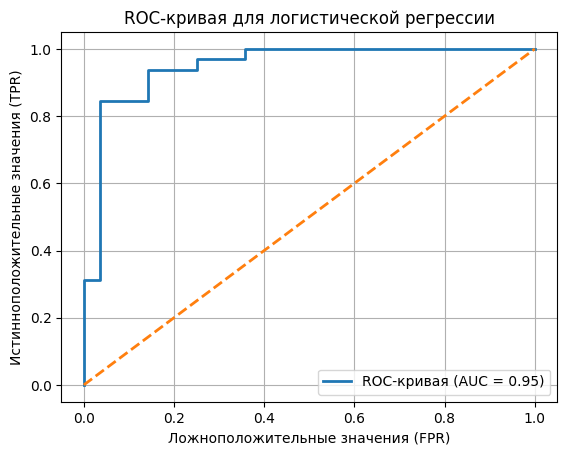

In [ ]:
fpr, tpr, _ = roc_curve(y_class_test, y_class_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr,  lw=2, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1],  lw=2, linestyle='--')
plt.xlabel('Ложноположительные значения (FPR)')
plt.ylabel('Истинноположительные значения (TPR)')
plt.title('ROC-кривая для логистической регрессии')
plt.grid()
plt.legend()
plt.show()

Теперь получим метрики при различных пороговых значениях

In [ ]:
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

for threshold in thresholds:
    y_class_pred_threshold = (y_class_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_class_test, y_class_pred_threshold)
    precision = precision_score(y_class_test, y_class_pred_threshold)
    recall = recall_score(y_class_test, y_class_pred_threshold)
    f1 = f1_score(y_class_test, y_class_pred_threshold)
    print(f"Порог: {threshold:.1f}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}\n")

Порог: 0.1, Accuracy: 0.83, Precision: 0.76, Recall: 1.00, F1-score: 0.86

Порог: 0.3, Accuracy: 0.90, Precision: 0.88, Recall: 0.94, F1-score: 0.91

Порог: 0.5, Accuracy: 0.87, Precision: 0.90, Recall: 0.84, F1-score: 0.87

Порог: 0.7, Accuracy: 0.85, Precision: 0.96, Recall: 0.75, F1-score: 0.84

Порог: 0.9, Accuracy: 0.67, Precision: 0.93, Recall: 0.41, F1-score: 0.57



Выводы по пункту "Классификация":

Как можно увидеть, Roc кривая находится выше случайного предсказания. Значит, модель обучена правильно.  
На основе полученных метрик наиболее оптимальным значением порога стало `0.3`, поскольку оно имеет наибольщие значения `F1-score` и `Accuracy`, а значит, и более точные предсказания.